In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene

import numpy as np
import matplotlib.pyplot as plt

# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

2023-12-30 23:59:53,079	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define generators
gens = Generator(name='gens',
                 value=np.zeros(data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(data.generator['p_forecast'].shape),
                 upper_bound=data.generator['p_forecast'],
                 cost=data.generator['cost_parameter_b'],
                 cost_nde=data.generator['cost_nde'],
                 is_renewable=data.generator['type_generator'])

# Define loads
loads = Load(name='loads',
             value=data.load['p_forecast'],
             lower_bound=np.zeros(data.load['p_forecast'].shape),
             upper_bound=data.load['p_forecast'],
             cost=np.ones(data.load['p_forecast'].shape),
             cost_cut=data.load['cost_cut'],
             cost_reduce=data.load['cost_reduce'],
             cost_ens=data.load['cost_ens'])

# Define storage
stor = Storage(name='stor',
               value=np.zeros(data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(data.storage['p_charge_limit'].shape),
               upper_bound=(data.storage['energy_capacity'] *
                            np.ones(data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(data.storage['p_charge_limit'].shape),
               cost_discharge=data.storage['discharge_price'],
               cost_charge=data.storage['charge_price'],
               capacity_max=data.storage['energy_capacity'],
               capacity_min=data.storage['energy_min_percentage'],
               initial_charge=data.storage['initial_state'],
               discharge_efficiency=data.storage['discharge_efficiency'],
               discharge_max=data.storage['p_discharge_limit'],
               charge_efficiency=data.storage['charge_efficiency'],
               charge_max=data.storage['p_charge_limit'],
               capital_cost=np.array([0.05250, 0.10500, 0.01575]))

# Define vehicle to grid
v2g = Vehicle(name='evs',
              value=np.zeros(data.vehicle['schedule_charge'].shape),
              lower_bound=(data.vehicle['e_capacity_max'] * data.vehicle['min_technical_soc'] *
                           np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(data.vehicle['e_capacity_max'] * np.ones(data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(data.vehicle['schedule_charge'].shape),
              cost_discharge=data.vehicle['discharge_price'][:, 0],
              cost_charge=data.vehicle['charge_price'][:, 0],
              capacity_max=data.vehicle['e_capacity_max'],
              initial_charge=np.ones(data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=data.vehicle['min_technical_soc'],
              discharge_efficiency=data.vehicle['discharge_efficiency'],
              charge_efficiency=data.vehicle['charge_efficiency'],
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063]),
              schedule_discharge=data.vehicle['schedule_discharge'],
              schedule_charge=data.vehicle['schedule_charge'])

# Define imports and exports
pimp = BinaryResource(name='pImp',
                      value=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['import_contracted_p_max'][0, :],
                      cost=data.peers['buy_price'][0, :],
                      is_active=np.zeros(data.peers['import_contracted_p_max'][0, :].shape))

pexp = BinaryResource(name='pExp',
                      value=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=data.peers['export_contracted_p_max'][0, :],
                      cost=data.peers['sell_price'][0, :],
                      is_active=np.zeros(data.peers['export_contracted_p_max'][0, :].shape))

# Establish the components
ec_components = {'gen': gens,
                 'loads': loads,
                 'stor': stor,
                 'evs': v2g,
                 'pimp': pimp,
                 'pexp': pexp}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [4]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=data,
                       n_iter=50000, iter_tolerance=1000)
scene.initialize()
scene.run()

100%|██████████| 50000/50000 [22:07<00:00, 37.66it/s]


In [5]:
 # Check the population

scene.algo.population

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [6]:
scene.current_best

{'genActPower': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.50611314,  1.44112333,  3.39406192,  5.74196925,  7.57284806,
          8.7607104 ,  9.41548428,  9.3744498 ,  8.62090335,  7.44523235,
          5.62898008,  3.16588254,  1.32672928,  0.46765165,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , 10.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        , 10.        ,
         10.        , 10.        ,  0.        , 10.        ,  0.        ,
          0.        ,  0.        ,  0.        ,

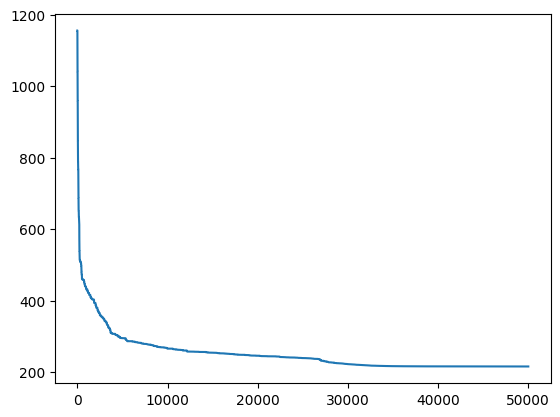

In [7]:
plt.plot(scene.algo.population_history_fitness)

In [8]:
scene.algo.population_history_fitness

[1156.5327892582177,
 1156.5327892582177,
 1130.7449117233639,
 1130.7449117233639,
 1130.7449117233639,
 1111.9632816482758,
 1111.9632816482758,
 1108.0116132558999,
 1108.0116132558999,
 1103.125882299275,
 1079.852183391313,
 1079.852183391313,
 1079.852183391313,
 1061.8070734254215,
 1061.8070734254215,
 1061.8070734254215,
 1061.8070734254215,
 1041.4845387167081,
 1041.4845387167081,
 1041.4845387167081,
 1009.8376548668679,
 1003.8199578023535,
 1003.8199578023535,
 1002.0420130646439,
 1002.0420130646439,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 959.5190673434412,
 940.4357580162186,
 940.4357580162186,
 940.4357580162186,
 901.4818632514433,
 901.4818632514433,
 901.4818632514433,
 901.4818632514433,
 901.4818632514433,
 897.9149276548915,
 894.9506911485109,
 889.2796638339172,
 861.6865450820147,

In [9]:
scene.algo.population_fitness

[215.7794405303971,
 215.77932861799243,
 215.7795300511416,
 215.77950731549424,
 215.77940102698872,
 215.77943969972327,
 215.77951828654338,
 215.7839532208068,
 215.77950240053698,
 215.77944101542369]